In [ ]:
# Getting Data from GitHub
!wget --no-check-certificate \
    https://github.com/omidmno2/stockMarketPrediction_DL/raw/main/tse_en.csv \
    -o /tmp/tse_en.csv

In [ ]:
# Import required libraries
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [ ]:
# Select the desired symbol
df = pd.read_csv("tse_en.csv")
df[df.Symbol == "غپينو"].head()

,Date,Symbol,Name,Yesterday,Open,Last,Close,Close Changes,Low,High,Number Traded,Volume,Value Traded
2726,2009-01-13,غپينو,پارس‌ مينو,1179,1179,1179,1179,0,1179.0,1179.0,2,3000,3537000
3656,2009-01-25,غپينو,پارس‌ مينو,1179,1144,1144,1179,0,1144.0,1144.0,1,500,572000
5328,2009-02-11,غپينو,پارس‌ مينو,1179,1144,1144,1172,-7,1144.0,1144.0,7,10690,12229360
6484,2009-03-01,غپينو,پارس‌ مينو,1172,1000,1136,1115,-57,1000.0,1136.0,5,18005,20067984
6998,2009-03-08,غپينو,پارس‌ مينو,1115,1082,1082,1114,-1,1082.0,1082.0,1,1000,1082000


In [ ]:
# Data cleaning
data = df[df.Symbol == "غپينو"]
data.index = pd.to_datetime(data['Date'])
data = data.drop(columns=['Symbol', 'Name', 'Date']).dropna()
data = data.head(2110)

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

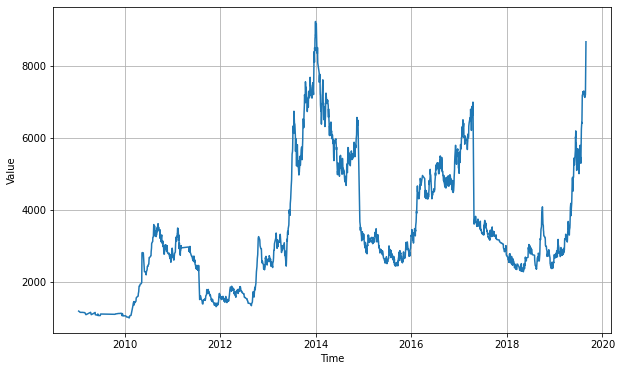

In [ ]:
# Data plotting
series = np.array(data["Last"])
time = np.array(data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
# Install pyts library for use Gramian Angular Field(GAF) and Markov Transition Field(MTF) method to create 2D pictures
!pip install pyts

     |████████████████████████████████| 2.5 MB 4.9 MB/s 


In [ ]:
from pyts.image import GramianAngularField, MarkovTransitionField
#https://johannfaouzi.github.io/pyts/index.html

In [ ]:
data.head(3)

,Yesterday,Open,Last,Close,Close Changes,Low,High,Number Traded,Volume,Value Traded
Date,,,,,,,,,,
2009-01-13,1179,1179,1179,1179,0,1179.0,1179.0,2,3000,3537000
2009-01-25,1179,1144,1144,1179,0,1144.0,1144.0,1,500,572000
2009-02-11,1179,1144,1144,1172,-7,1144.0,1144.0,7,10690,12229360


In [ ]:
# GAF transformations
image_size = 20
window_size = 60

gaf = GramianAngularField(image_size)
windows_gaf = []
for i in range(len(data.Last) - window_size):
    window = np.array(data.Last[i:i + window_size]).reshape(1, -1)
    #window = data[i:i + window_size].transpose()
    window_gaf = gaf.fit_transform(window)
    windows_gaf.append(window_gaf[0])
    #windows_gaf.append(window_gaf)

In [ ]:
gaf.fit_transform(window).shape

(1, 20, 20)

In [ ]:
# MTF transformation
image_size = 20
window_size = 60

mtf = MarkovTransitionField(image_size)
windows_mtf = []
for i in range(len(data) - window_size):
    window = np.array(data.Last[i:i + window_size]).reshape(1, -1)
    #window = data[i:i + window_size].transpose()
    window_mtf = mtf.fit_transform(window)
    windows_mtf.append(window_mtf[0])
    #windows_mtf.append(window_mtf)

In [ ]:
mtf.fit_transform(window).shape

(1, 20, 20)

In [ ]:
def show_image_list(list_images, list_titles=None, cmap='rainbow', num_cols=8, figsize=(20, 20), title_fontsize=10):
    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

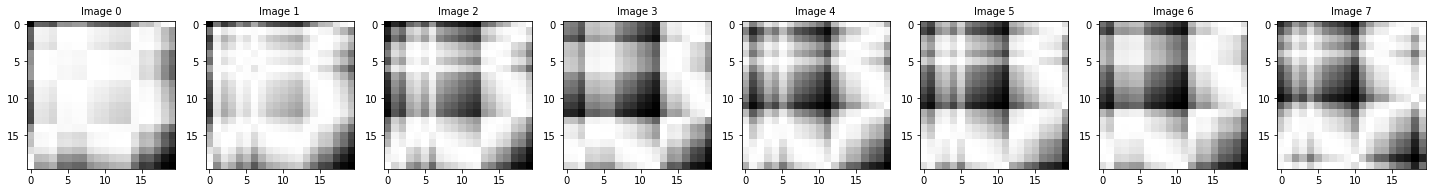

In [ ]:
show_image_list(windows_gaf[0:8], cmap='binary')

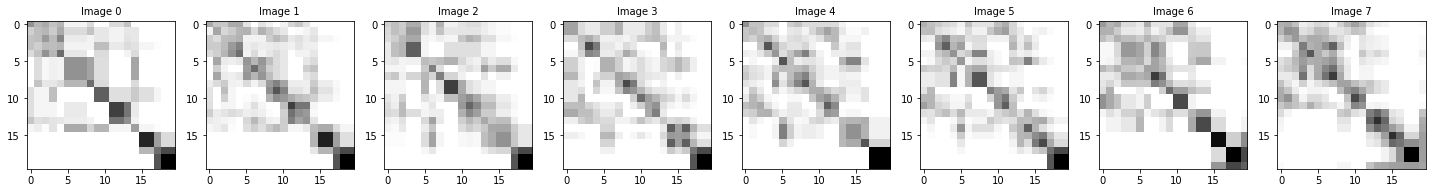

In [ ]:
show_image_list(windows_mtf[0:8], cmap='binary')

In [ ]:
len(windows_gaf)

2050

In [ ]:
len(data.Last[60:])

2050

In [ ]:
# Algorithm 1
# Labeling (Buy, Sell, Hold)

window_size = 11
counter = 0
bsh_labels = []

window_begin_idx=0
window_end_idx=0
window_middle_idx=0

min_idx=0
max_idx=0
number=0.0
mins=10000.0
maxs=0.0
while counter < len(data.Last):
    if counter > window_size:
        window_begin_idx = counter - window_size
        window_end_idx = window_begin_idx + window_size - 1
        window_middle_idx = (window_begin_idx + window_end_idx)//2
        for i in range(window_begin_idx, window_end_idx+1):
            number = data.Last[i]
            if number < mins:
                mins=number
                min_idx = np.where(data.Last==mins)[0][0]
            if number > maxs:
                maxs=number
                max_idx = np.where(data.Last==maxs)[0][0]
        if max_idx == window_middle_idx:
            bsh_labels.append(0) #SELL
        elif min_idx == window_middle_idx:
            bsh_labels.append(1) #BUY
        else:
            bsh_labels.append(2) #HOLD  
        mins = 10000.0
        maxs = 0.0
    counter+=1

In [ ]:
len(bsh_labels)

2098

In [ ]:
len(data.Last)

2110

In [ ]:
len(data.Last) - len(bsh_labels)
# You should remove 6 rows from head and 6 rows from tail of data or actualy pictures.
# After checking, it was found that this difference is due to the fact that 6 lines from the top and 6 lines from the bottom have been removed.
# شش تای اول و شش تای آخر حذف میشوند موقع درست کردن لیبل

12

In [ ]:
bsh_labels = bsh_labels[54:]
windows_gaf = windows_gaf[:-6]
windows_mtf = windows_mtf[:-6]
print(len(bsh_labels))
print(len(windows_gaf))
print(len(windows_mtf))

2044
2044
2044


In [ ]:
# Divide the data into training and validation data for GAF
split_time = 1800
y_train = bsh_labels[:split_time]
x_train = windows_gaf[:split_time]
y_valid = bsh_labels[split_time:]
x_valid = windows_gaf[split_time:]

y_train = np.array(y_train)
x_train = np.array(x_train)
y_valid = np.array(y_valid)
x_valid = np.array(x_valid)

y_train = tf.keras.utils.to_categorical(y_train, 3)
y_valid = tf.keras.utils.to_categorical(y_valid, 3)

In [ ]:
# Create and train the model for GAF
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 1)),
    #tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 10)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 18, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 6, 128)         0         
                                                        

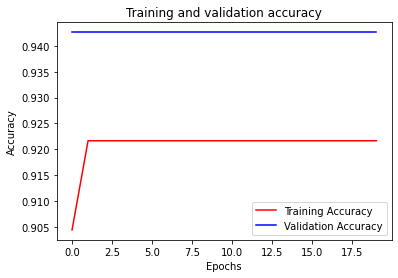

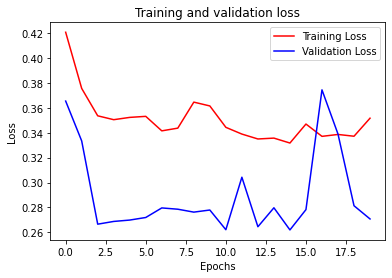

In [ ]:
# Ploting accuracy and loss diagrams for GAF
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure().add_subplot(xlabel='Epochs', ylabel='Accuracy')
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure().add_subplot(xlabel='Epochs', ylabel='Loss')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [ ]:
# Divide the data into training and validation data for MTF
split_time = 1800
y_train = bsh_labels[:split_time]
x_train = windows_mtf[:split_time]
y_valid = bsh_labels[split_time:]
x_valid = windows_mtf[split_time:]

y_train = np.array(y_train)
x_train = np.array(x_train)
y_valid = np.array(y_valid)
x_valid = np.array(x_valid)

y_train = tf.keras.utils.to_categorical(y_train, 3)
y_valid = tf.keras.utils.to_categorical(y_valid, 3)

In [ ]:
# Create and train the model for MTF
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 1)),
    #tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 10)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 18, 18, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 128)         0         
                                                      

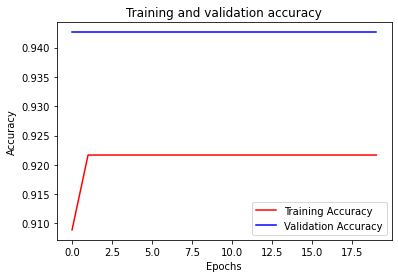

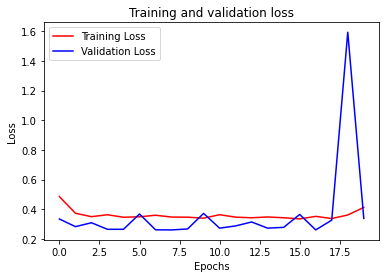

In [ ]:
# Ploting accuracy and loss diagrams for MTF
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure().add_subplot(xlabel='Epochs', ylabel='Accuracy')
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure().add_subplot(xlabel='Epochs', ylabel='Loss')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [ ]:
# Test Up and Down labeling method
data.head()

,Yesterday,Open,Last,Close,Close Changes,Low,High,Number Traded,Volume,Value Traded
Date,,,,,,,,,,
2009-01-13,1179,1179,1179,1179,0,1179.0,1179.0,2,3000,3537000
2009-01-25,1179,1144,1144,1179,0,1144.0,1144.0,1,500,572000
2009-02-11,1179,1144,1144,1172,-7,1144.0,1144.0,7,10690,12229360
2009-03-01,1172,1000,1136,1115,-57,1000.0,1136.0,5,18005,20067984
2009-03-08,1115,1082,1082,1114,-1,1082.0,1082.0,1,1000,1082000


In [ ]:
# labeling Up or Down

ud_labels = []

for i in range(1, len(data.Last)):
    if data.Last[i] < data.Last[i-1]:
        ud_labels.append(0) # 0 = Down
    else:
        ud_labels.append(1) # 1 = Up
        
# This method miss first row from data, you should remove first row then train it

ud_labels = ud_labels[59:-6]
len(ud_labels)

2044

In [ ]:
len(windows_gaf)

2044

In [ ]:
# Divide the data into training and validation data for GAF
split_time = 1800
y_train = ud_labels[:split_time]
x_train = windows_gaf[:split_time]
y_valid = ud_labels[split_time:]
x_valid = windows_gaf[split_time:]

y_train = np.array(y_train)
x_train = np.array(x_train)
y_valid = np.array(y_valid)
x_valid = np.array(x_valid)

#y_train = tf.keras.utils.to_categorical(y_train, 2)
#y_valid = tf.keras.utils.to_categorical(y_valid, 2)

In [ ]:
# Create and train the model for GAF
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='softmax')
])

model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 18, 18, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 128)         0         
                                                      

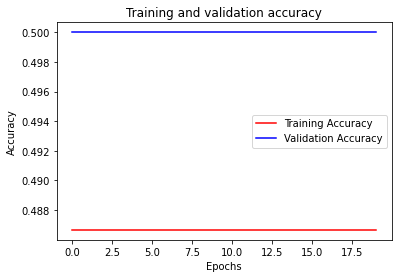

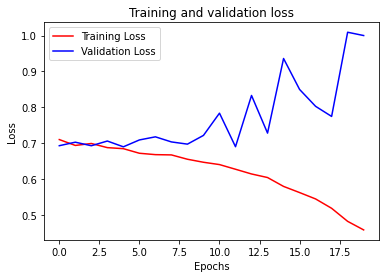

In [ ]:
# Ploting accuracy and loss diagrams for GAF
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure().add_subplot(xlabel='Epochs', ylabel='Accuracy')
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure().add_subplot(xlabel='Epochs', ylabel='Loss')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [ ]:
# Divide the data into training and validation data for MTF
split_time = 1800
y_train = ud_labels[:split_time]
x_train = windows_mtf[:split_time]
y_valid = ud_labels[split_time:]
x_valid = windows_mtf[split_time:]

y_train = np.array(y_train)
x_train = np.array(x_train)
y_valid = np.array(y_valid)
x_valid = np.array(x_valid)

#y_train = tf.keras.utils.to_categorical(y_train, 2)
#y_valid = tf.keras.utils.to_categorical(y_valid, 2)

In [ ]:
# Create and train the model for MTF
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='softmax')
])

model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 18, 18, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 6, 6, 128)         0         
                                                      

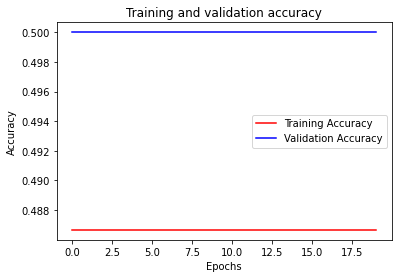

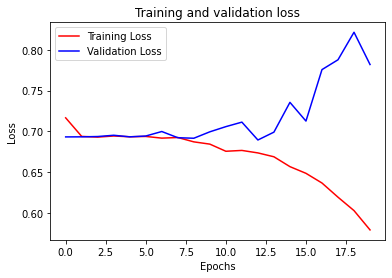

In [ ]:
# Ploting accuracy and loss diagrams for MTF
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure().add_subplot(xlabel='Epochs', ylabel='Accuracy')
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure().add_subplot(xlabel='Epochs', ylabel='Loss')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()